In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, Fourier
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [5]:
train_df = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
train_df.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [6]:
train_df.tail(3)

,id,date,store_nbr,family,sales,onpromotion
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [7]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
test.head(3)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


### stores.csv
Храните метаданные, в том числе город, состояние, Типи кластер.
кластер представляет собой группировку похожих магазинов.

In [8]:
stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


Этот файл нужно присоединить к основному по id=store_nbr

### oil Ежедневная цена на нефть в таблице oil

In [9]:
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
oil.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


<AxesSubplot:xlabel='date'>

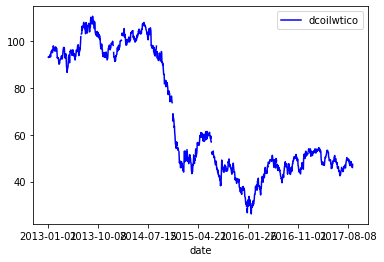

In [10]:
#oil = oil.loc[oil['date'] >= '2017']
oil.plot(x ='date', y='dcoilwtico',color="blue")

<AxesSubplot:xlabel='date'>

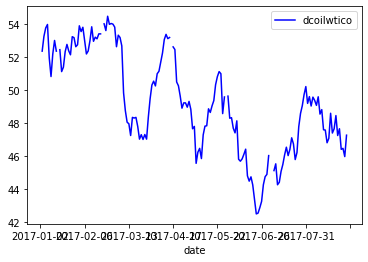

In [11]:
oil2 = oil.loc[oil['date'] >= '2017']
oil2.plot(x ='date', y='dcoilwtico',color="blue")

### holidays_events.csv Праздники и события с метаданными
Обратите особое внимание на столбец "Перенесено"=transferred. Праздник, который официально переносится, приходится на этот календарный день, но правительство перенесло его на другую дату. Перенесенный день больше похож на обычный день, чем на праздник. Чтобы найти день, в который он действительно отмечался, найдите соответствующую строку, где тип - Передача. Например, праздник Независимости Гуаякиля был перенесен с 2012-10-09 на 2012-10-12, что означает, что он отмечался в 2012-10-12. Дни, относящиеся к типу Bridge, - это дополнительные дни, которые добавляются к празднику (например, для продления перерыва на долгие выходные). Они часто составляются по типу рабочего дня, который обычно не запланирован для работы (например, суббота), который предназначен для окупаемости моста.
Дополнительные праздничные дни - это дни, добавленные к обычному календарному празднику, например, как это обычно бывает на Рождество (что делает Сочельник праздником

In [12]:
holidays_events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
holidays_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [13]:
holidays_events.tail(5)

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


<AxesSubplot:>

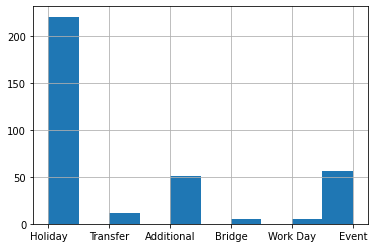

In [14]:
holidays_events['type'].hist()

In [15]:
holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

# Начну рассматривать таблицу train_df

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [17]:
train_df.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [18]:
print('Всего уникальных значений family=',len(train_df['family'].unique()))

Всего уникальных значений family= 33


### Посмотрю как продажи в каждом магазине

<AxesSubplot:xlabel='date,store_nbr'>

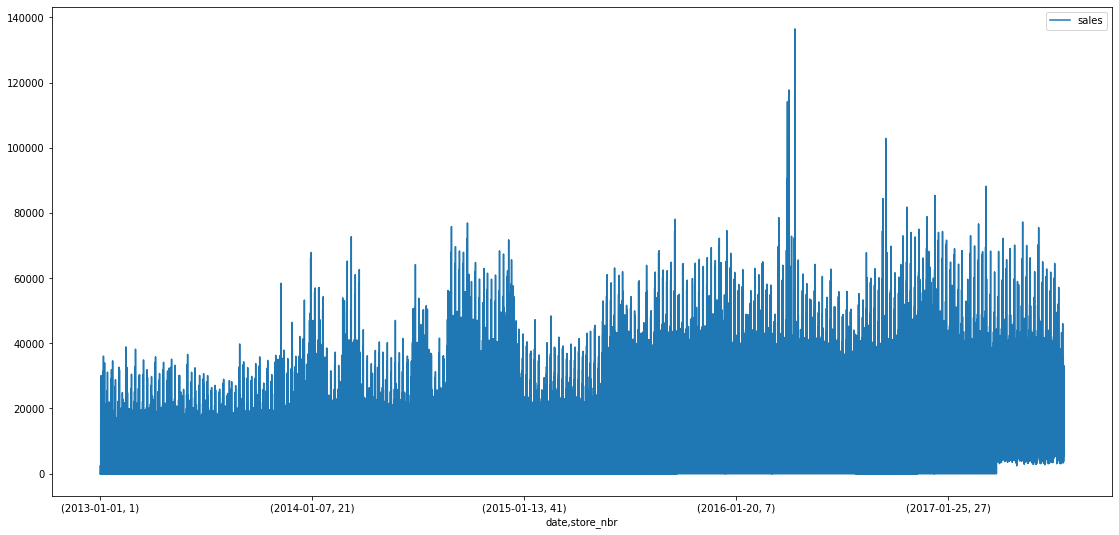

In [19]:
train_df.pivot_table(index=['date','store_nbr'],values='sales',aggfunc='sum').plot(figsize=(19, 9))

### Рассмотрю продажи по месяцам

In [20]:
#train_df['date'] = pd.to_datetime(train_df['date'], format = '%d.%m.%Y')
train_df['date'] = pd.to_datetime(train_df['date'], format = '%Y.%m.%d')
train_df['month'] = train_df['date'].dt.to_period('1M')
train_df.head(10)

,id,date,store_nbr,family,sales,onpromotion,month
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01
2,2,2013-01-01,1,BEAUTY,0.0,0,2013-01
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013-01
4,4,2013-01-01,1,BOOKS,0.0,0,2013-01
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,2013-01
6,6,2013-01-01,1,CELEBRATION,0.0,0,2013-01
7,7,2013-01-01,1,CLEANING,0.0,0,2013-01
8,8,2013-01-01,1,DAIRY,0.0,0,2013-01
9,9,2013-01-01,1,DELI,0.0,0,2013-01


In [21]:
train_df.tail(3)

,id,date,store_nbr,family,sales,onpromotion,month
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017-08
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017-08
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,2017-08


<AxesSubplot:xlabel='month,store_nbr'>

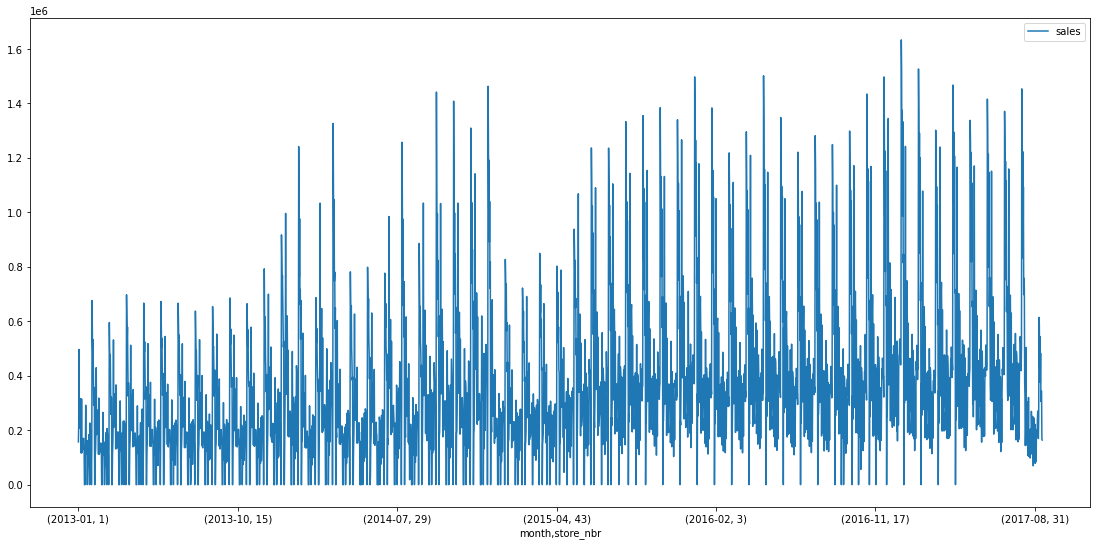

In [22]:
train_df.pivot_table(index=['month','store_nbr'],values='sales',aggfunc='sum').plot(figsize=(19, 9))

#### Посмотрю на график продаж вместе с 7-дневней средней

<AxesSubplot:xlabel='date'>

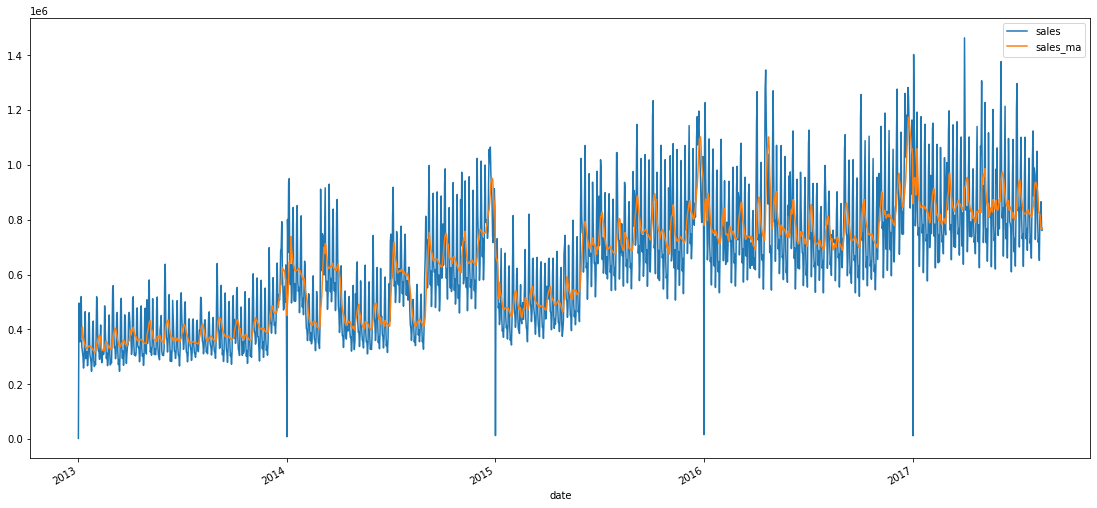

In [23]:
# data
from plotly.subplots import make_subplots
df_sales = train_df.groupby('date').agg({"sales" : "sum"}).reset_index()

df_sales['sales_ma'] = df_sales['sales'].rolling(7).mean()
#df_trans = train_df.groupby('date').agg({"transactions" : "sum"}).reset_index()
#df_trans['transactions_ma'] = df_trans['transactions'].rolling(7).mean()

df_sales=df_sales.set_index('date')
df_sales.plot(figsize=(19, 9))




<AxesSubplot:xlabel='date'>

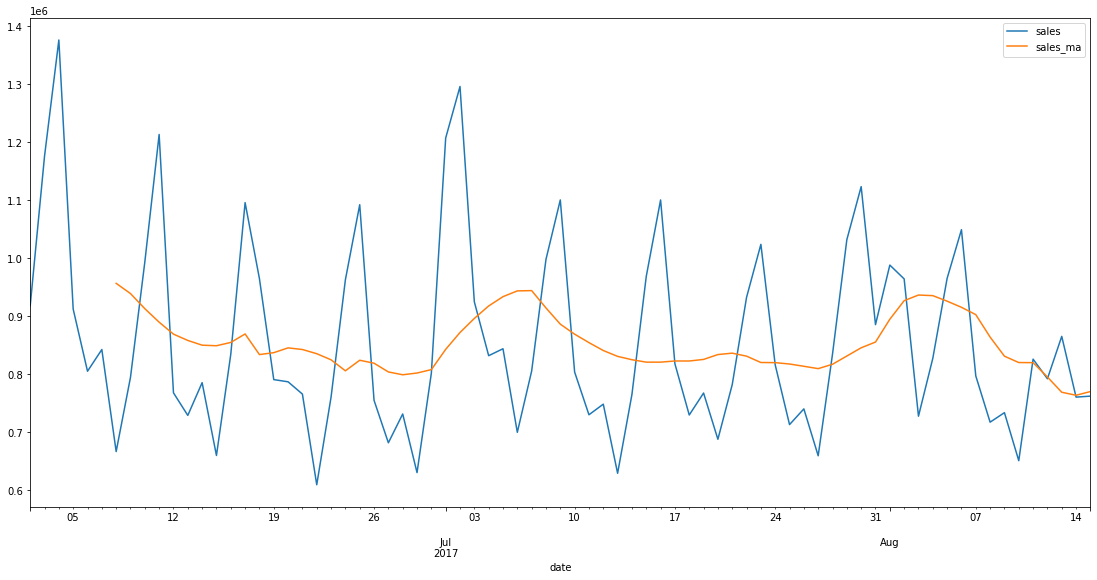

In [24]:
d='2017-06-01'
df_sales = train_df.query('date>@d').groupby('date').agg({"sales" : "sum"}).reset_index()

df_sales['sales_ma'] = df_sales['sales'].rolling(7).mean()
#df_trans = train_df.groupby('date').agg({"transactions" : "sum"}).reset_index()
#df_trans['transactions_ma'] = df_trans['transactions'].rolling(7).mean()

df_sales=df_sales.set_index('date')
df_sales.plot(figsize=(19, 9))

#### Общие Продажи в каждом магазине

<AxesSubplot:xlabel='store_nbr'>

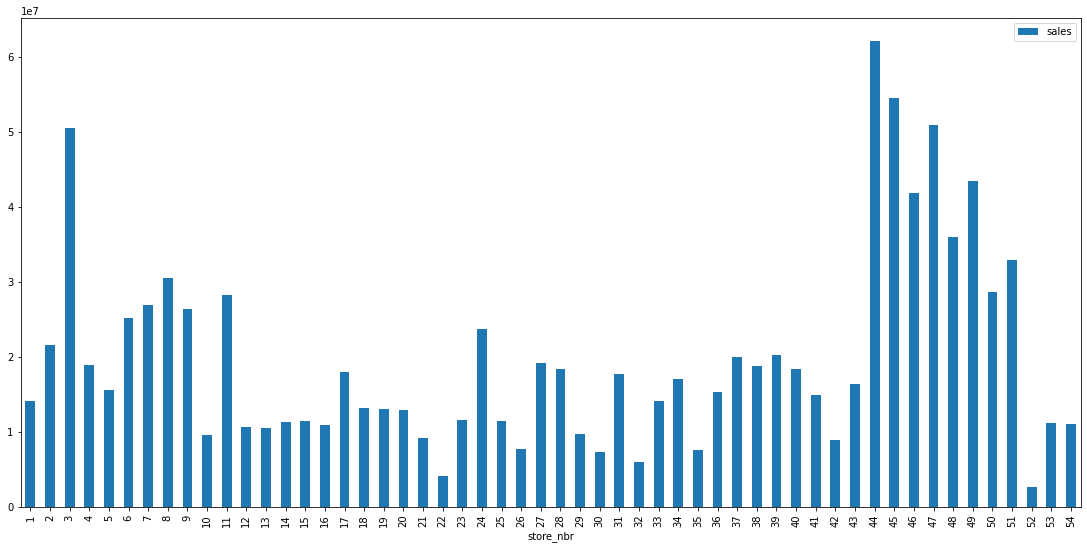

In [25]:
train_df.pivot_table(index='store_nbr',values='sales',aggfunc='sum').plot(kind='bar',figsize=(19, 9))

#### Общие продажи по каждому товару

<AxesSubplot:xlabel='family'>

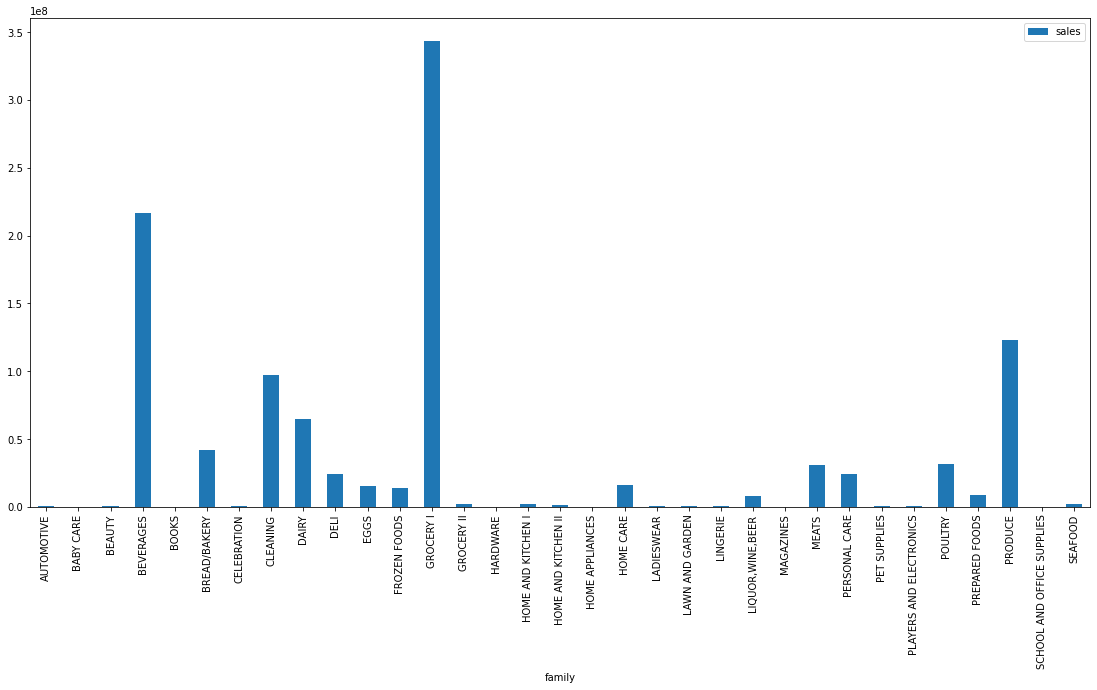

In [26]:
train_df.pivot_table(index='family',values='sales',aggfunc='sum').plot(kind='bar',figsize=(19, 9))

Имеются продукты, которые хорошо или плохо продаются

### Посматрю на то какой ассортимент продается в каждом магазине

In [27]:
train_df.pivot_table(index=['date','store_nbr'],values='family',aggfunc='count').query('family<33')

,,family
date,store_nbr,


Как видно в каждом магазине продаются все виды товаров

In [28]:
print('Всего магазинов=',train_df['store_nbr'].max())

Всего магазинов= 54


### График продаж по товарам

<AxesSubplot:xlabel='month'>

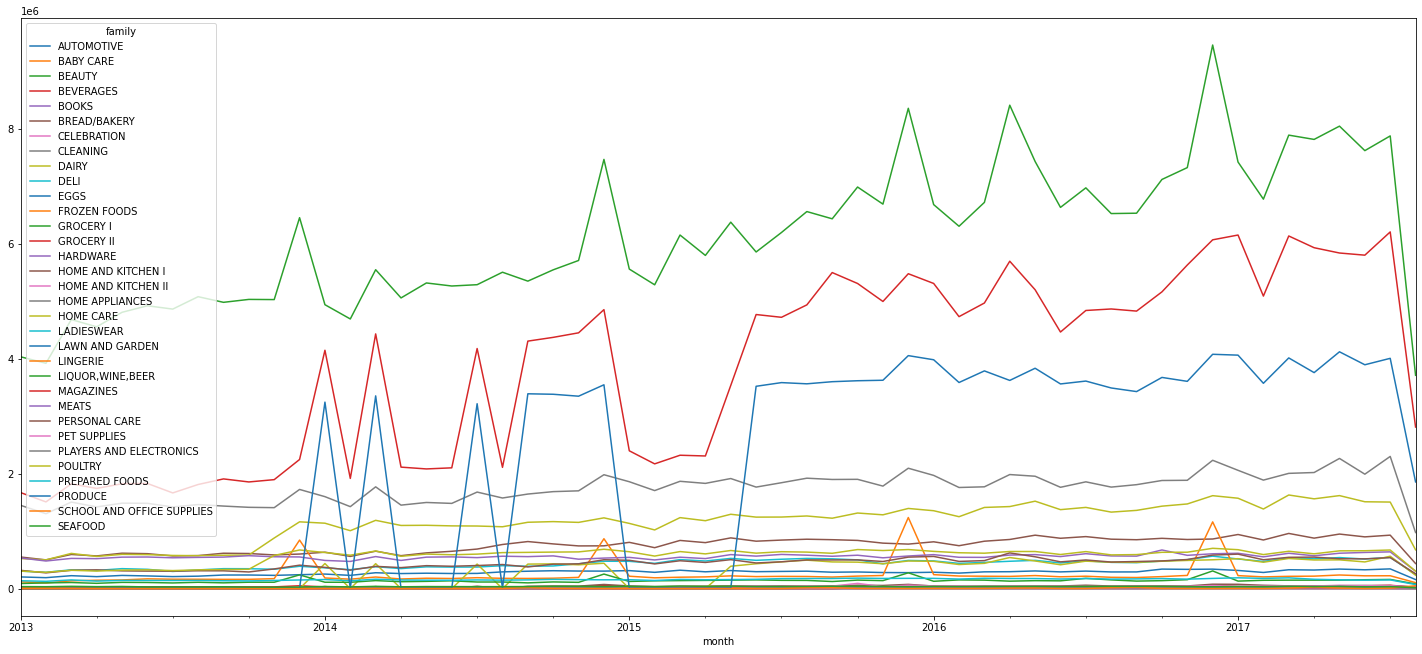

In [30]:
train_df.pivot_table(index='month',values='sales',columns='family',aggfunc='sum').plot(figsize=(25, 11))

<AxesSubplot:xlabel='month'>

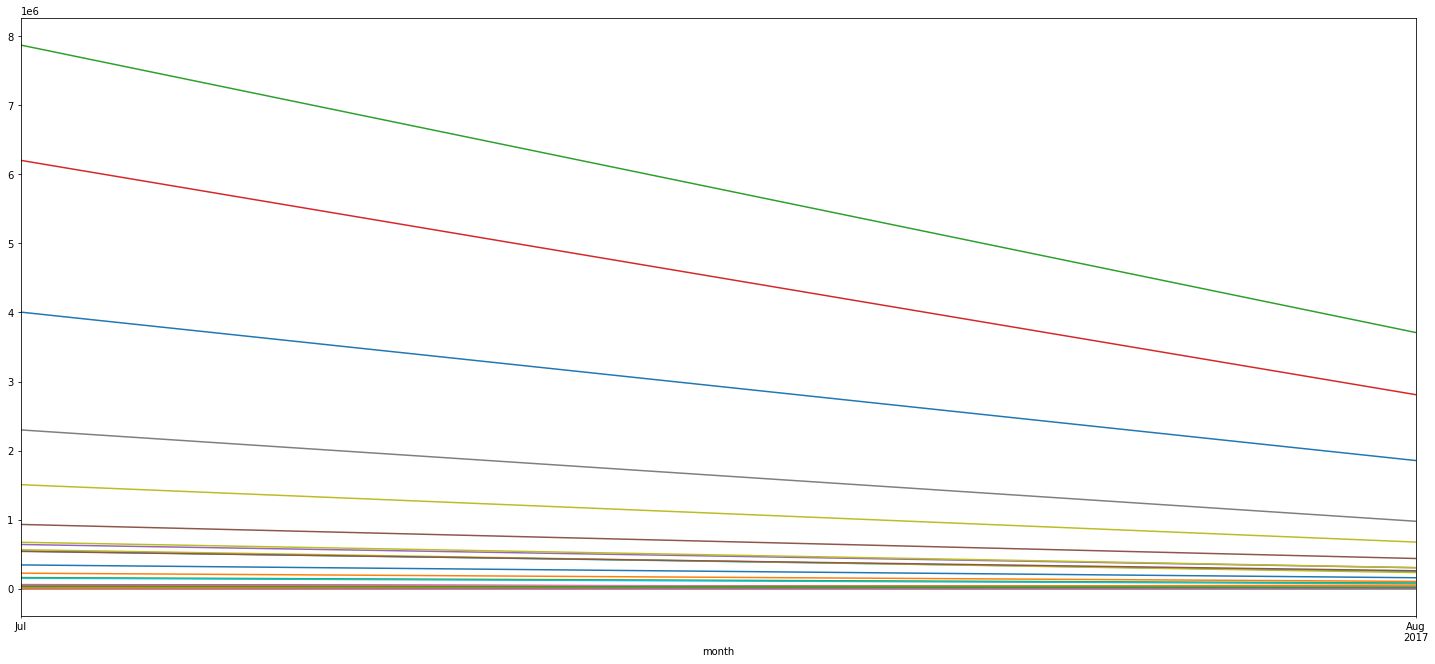

In [31]:
d='2017-06-30'
train_df.query('date>@d').pivot_table(index='month',values='sales',columns='family',aggfunc='sum').plot(figsize=(25, 11),legend=False)

### График продаж во всех магазинах

<AxesSubplot:xlabel='month'>

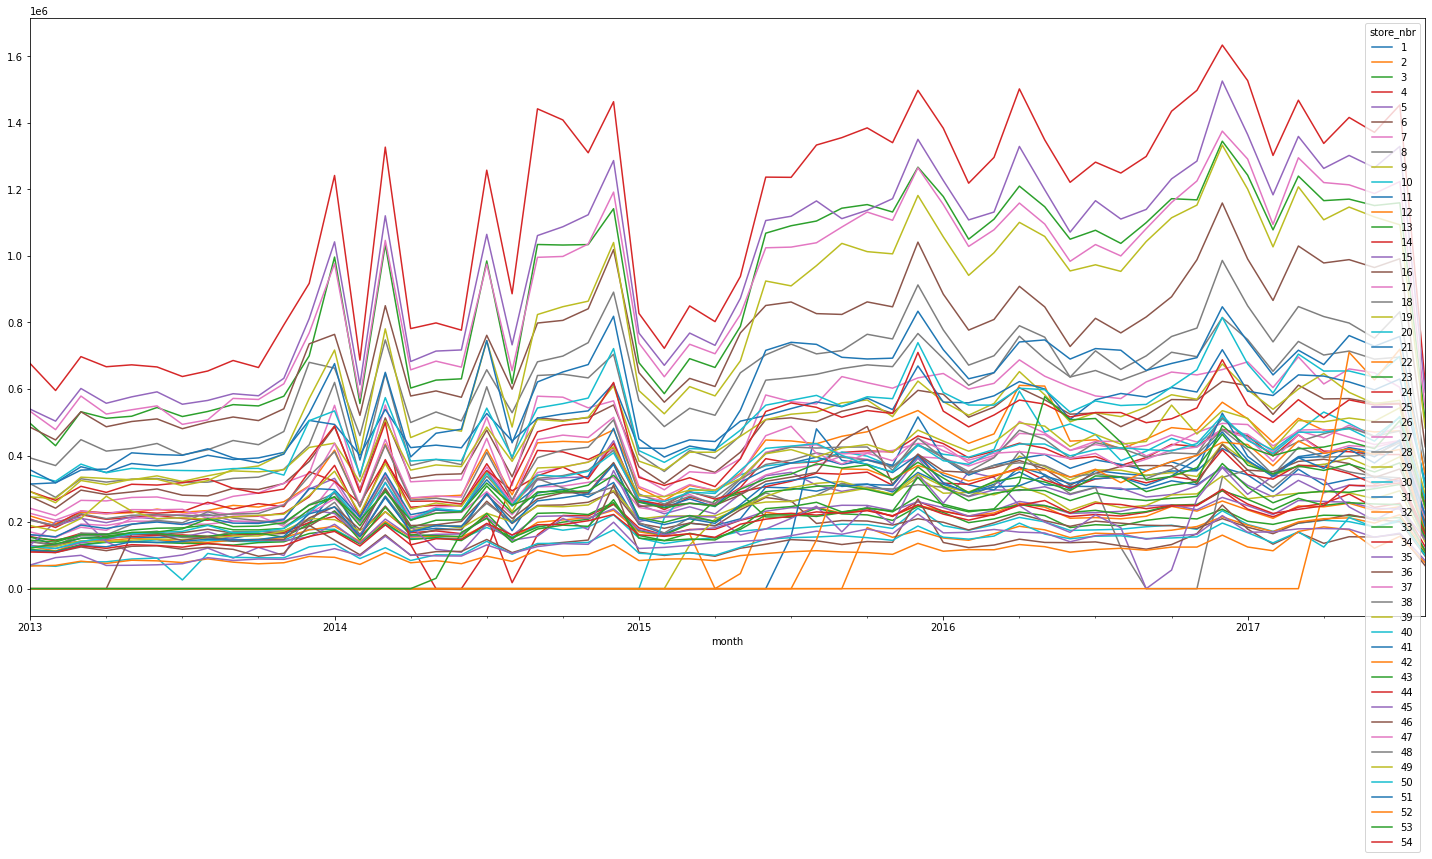

In [32]:
train_df.pivot_table(index='month',values='sales',columns='store_nbr',aggfunc='sum').plot(figsize=(25, 11))

<AxesSubplot:xlabel='month'>

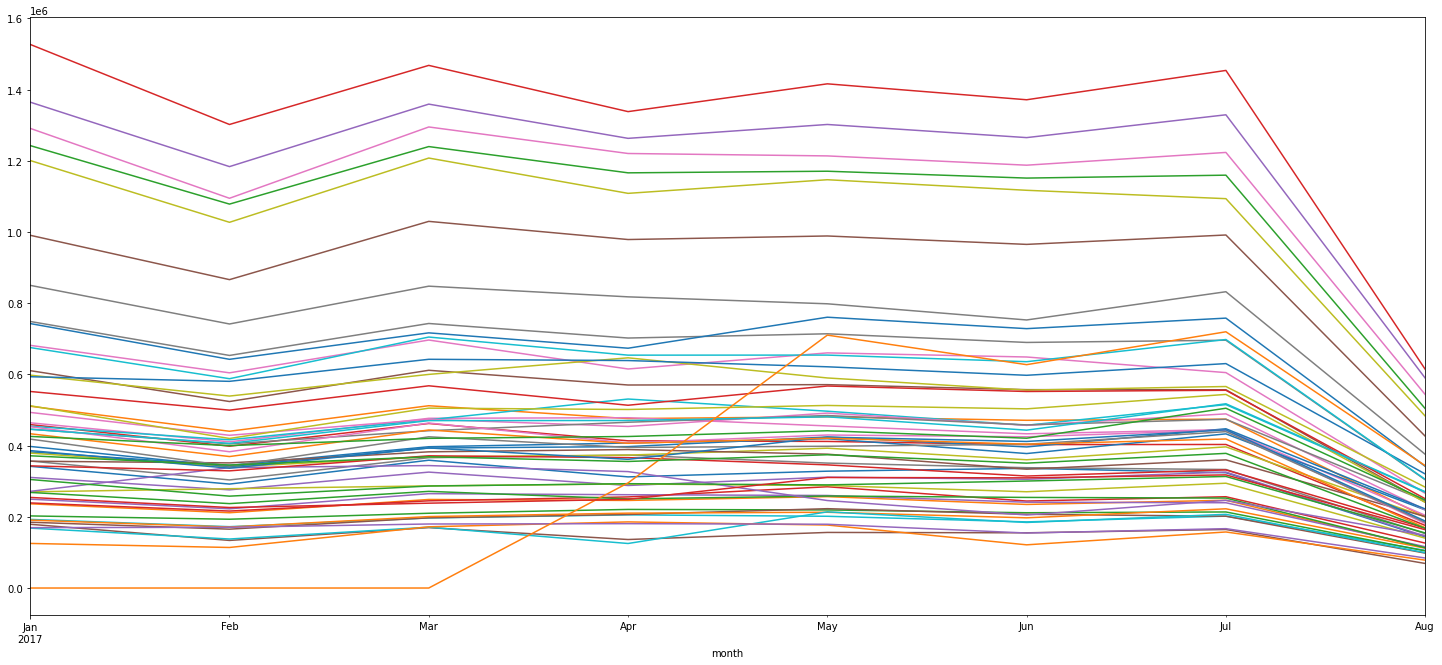

In [33]:
d=2017
train_df.query('date>@d').pivot_table(index='month',values='sales',columns='store_nbr',aggfunc='sum').plot(figsize=(25, 11),legend=False)

## Вывод как видно в конце июня 2017 продажи начинают падать , т.е в конец периода, а это аномальные значения, которые нельзя выкинуть. Принял решения, что лучше обучить модель на последних данных так как они лучше отображают будущие продажи

## Рассмотрим модель которая будет обучаться, на последних данных

In [34]:
# Заново перезапишу данные
#путь к набору данных в записной книжке Kaggle
path = '../input/store-sales-time-series-forecasting/'

In [35]:
# Цена на нефть
data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')

########################################################################################################################
# Для цены на нефть вычислю скользящую среднию
########################################################################################################################
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean() # change 'None' to your answer


# Создам календарь
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

########################################################################################################################
# Добавлю в календарь цены на нефть
########################################################################################################################
calendar = calendar.merge(data_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='bfill', inplace=True)

calendar.head(15) # display some entries of calendar

,dcoilwtico,ma_oil
2013-01-01,NaN,93.218571
2013-01-02,93.14,93.218571
2013-01-03,92.97,93.218571
2013-01-04,93.12,93.218571
2013-01-05,NaN,93.218571
2013-01-06,NaN,93.218571
2013-01-07,93.20,93.218571
2013-01-08,93.21,93.218571
2013-01-09,93.08,93.218571
2013-01-10,93.81,93.218571


In [36]:
########################################################################################################################
# Добавлю в календарь дни недели
########################################################################################################################
calendar['wd'] = calendar.index.dayofweek # change 'None' to your answer

calendar.head(15) # display some entries of calendar

,dcoilwtico,ma_oil,wd
2013-01-01,NaN,93.218571,1
2013-01-02,93.14,93.218571,2
2013-01-03,92.97,93.218571,3
2013-01-04,93.12,93.218571,4
2013-01-05,NaN,93.218571,5
2013-01-06,NaN,93.218571,6
2013-01-07,93.20,93.218571,0
2013-01-08,93.21,93.218571,1
2013-01-09,93.08,93.218571,2
2013-01-10,93.81,93.218571,3


In [37]:
df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

df_train.head(15) # display some entries of the training data

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0
                     2013-01-06    2.0
                     2013-01-07    0.0
                     2013-01-08    2.0
                     2013-01-09    2.0
                     2013-01-10    2.0
                     2013-01-11    3.0
                     2013-01-12    2.0
                     2013-01-13    2.0
                     2013-01-14    2.0
                     2013-01-15    1.0

In [38]:
df_test = pd.read_csv(path + 'test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

df_test.head(15) # display some entries of the testing data

Empty DataFrame
Columns: []
Index: [(1, AUTOMOTIVE, 2017-08-16), (1, AUTOMOTIVE, 2017-08-17), (1, AUTOMOTIVE, 2017-08-18), (1, AUTOMOTIVE, 2017-08-19), (1, AUTOMOTIVE, 2017-08-20), (1, AUTOMOTIVE, 2017-08-21), (1, AUTOMOTIVE, 2017-08-22), (1, AUTOMOTIVE, 2017-08-23), (1, AUTOMOTIVE, 2017-08-24), (1, AUTOMOTIVE, 2017-08-25), (1, AUTOMOTIVE, 2017-08-26), (1, AUTOMOTIVE, 2017-08-27), (1, AUTOMOTIVE, 2017-08-28), (1, AUTOMOTIVE, 2017-08-29), (1, AUTOMOTIVE, 2017-08-30)]

### Обучение модели

In [39]:
# Установлю диапазон данных которые использую для обучения
sdate = '2017-04-01'
edate = '2017-08-15'

# обучим модель, которая принимает функцию даты в качестве входных данных и прогнозирует продажи для каждого магазина и семейства товаров на эту дату
y = df_train.unstack(['store_nbr', 'family']).loc[sdate:edate]


fourier = CalendarFourier(freq='W', order=4)

dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)

X = dp.in_sample() 


X['oil']  = calendar.loc[sdate:edate]['ma_oil'].values
X['wd']   = calendar.loc[sdate:edate]['wd'].values

X.head(15)

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",oil,wd
date,,,,,,,,,
2017-04-01,1.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,49.034286,5
2017-04-02,2.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.034286,6
2017-04-03,3.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.034286,0
2017-04-04,4.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,49.561429,1
2017-04-05,5.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,50.150000,2
2017-04-06,6.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,50.625714,3
2017-04-07,7.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,51.022857,4
2017-04-08,8.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,51.417143,5
2017-04-09,9.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,51.417143,6


In [40]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [41]:
# Посмотрим на результат работы

y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.262876
BABY CARE                     0.068387
BEAUTY                        0.269746
BEVERAGES                     0.193554
BOOKS                         0.027975
BREAD/BAKERY                  0.120456
CELEBRATION                   0.294605
CLEANING                      0.210812
DAIRY                         0.132261
DELI                          0.104360
EGGS                          0.140334
FROZEN FOODS                  0.168430
GROCERY I                     0.206394
GROCERY II                    0.353404
HARDWARE                      0.280179
HOME AND KITCHEN I            0.264055
HOME AND KITCHEN II           0.224661
HOME APPLIANCES               0.156139
HOME CARE                     0.119397
LADIESWEAR                    0.262420
LAWN AND GARDEN               0.259770
LINGERIE                      0.406804
LIQUOR,WINE,BEER              0.648438
MAGAZINES                     0.258742
MEATS                         0.114422
PERSONAL CARE     

## Предсказываю продажи

In [42]:
# Выделяю период 

stest = '2017-08-16'
etest = '2017-08-31'


X_test = dp.out_of_sample(steps=16) 

X_test['oil']  = calendar.loc[stest:etest]['ma_oil'].values
X_test['wd']   = calendar.loc[stest:etest]['wd'].values

print(X_test.head(10))

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])

sales_pred[sales_pred < 0] = 0. # Sales should be >= 0

            trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
2017-08-16  138.0           0.974928          -0.222521          -0.433884   
2017-08-17  139.0           0.433884          -0.900969          -0.781831   
2017-08-18  140.0          -0.433884          -0.900969           0.781831   
2017-08-19  141.0          -0.974928          -0.222521           0.433884   
2017-08-20  142.0          -0.781831           0.623490          -0.974928   
2017-08-21  143.0           0.000000           1.000000           0.000000   
2017-08-22  144.0           0.781831           0.623490           0.974928   
2017-08-23  145.0           0.974928          -0.222521          -0.433884   
2017-08-24  146.0           0.433884          -0.900969          -0.781831   
2017-08-25  147.0          -0.433884          -0.900969           0.781831   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
2017-08-16          -0.900969          -0.781831           0.623490   

In [43]:
# Фармирую данные для отправки на проверку

df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('submission.csv', index=True)

In [44]:
df_sub

,sales
id,
3000888,4.304066
3000889,0.000000
3000890,4.006828
3000891,2369.555628
3000892,0.409197
...,...
3029395,311.147676
3029396,85.045690
3029397,1172.375082
